###  Importing Basic Spark Libraries

In [1]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [3]:
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("kmeans_songs") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

In [4]:
spark

# EDA & Data Preparation

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('kmeans').getOrCreate()

### Load Data

In [6]:
df = spark.read.csv('music_data.csv', header=True, inferSchema=True)

In [7]:
df.show()

+--------------------+--------------------+--------------------+-----+
|              userid|            artistid|         artist_name|plays|
+--------------------+--------------------+--------------------+-----+
|00000c289a1829a80...|3bd73256-3905-4f3...|     betty blowtorch| 2137|
|00000c289a1829a80...|f2fb0ff0-5679-42e...|           die Ärzte| 1099|
|00000c289a1829a80...|b3ae82c2-e60b-455...|   melissa etheridge|  897|
|00000c289a1829a80...|3d6bbeb7-f90e-4d1...|           elvenking|  717|
|00000c289a1829a80...|bbd2ffd7-17f4-450...|juliette & the licks|  706|
|00000c289a1829a80...|8bfac288-ccc5-448...|red hot chili pep...|  691|
|00000c289a1829a80...|6531c8b1-76ea-414...|              magica|  545|
|00000c289a1829a80...|21f3573f-10cf-44b...|the black dahlia ...|  507|
|00000c289a1829a80...|c5db90c4-580d-4f3...|         the murmurs|  424|
|00000c289a1829a80...|0639533a-0402-40b...|          lunachicks|  403|
|00000c289a1829a80...|a342964d-ca53-4e5...|    walls of jericho|  393|
|00000

In [8]:
df.count()

999

### Select only Artist since we want artist clusters

In [9]:
df_artist = df.select(['artist_name', 'plays'])

In [10]:
df_artist.show(10)

+--------------------+-----+
|         artist_name|plays|
+--------------------+-----+
|     betty blowtorch| 2137|
|           die Ärzte| 1099|
|   melissa etheridge|  897|
|           elvenking|  717|
|juliette & the licks|  706|
|red hot chili pep...|  691|
|              magica|  545|
|the black dahlia ...|  507|
|         the murmurs|  424|
|          lunachicks|  403|
+--------------------+-----+
only showing top 10 rows



In [11]:
df_artist.count()

999

In [12]:
artist_aggr = df_artist.groupby('artist_name').sum()

In [13]:
artist_aggr.show(10)

+----------------+----------+
|     artist_name|sum(plays)|
+----------------+----------+
|        le tigre|       281|
|              l7|       135|
|             fog|       132|
|           hanna|         4|
| raymond & maria|       737|
|       amplifier|       175|
|     the beatles|      1041|
|      television|         7|
|    steel attack|       551|
|john jacob niles|        57|
+----------------+----------+
only showing top 10 rows



In [14]:
artist_aggr.count()

857

In [15]:
artist_aggr.columns

['artist_name', 'sum(plays)']

In [16]:
artist_aggr.select('sum(plays)').show(10)

+----------+
|sum(plays)|
+----------+
|       281|
|       135|
|       132|
|         4|
|       737|
|       175|
|      1041|
|         7|
|       551|
|        57|
+----------+
only showing top 10 rows



In [17]:
artist_data = artist_aggr.withColumnRenamed("sum(plays)", "plays_sum")

In [18]:
artist_data.show(10)

+----------------+---------+
|     artist_name|plays_sum|
+----------------+---------+
|        le tigre|      281|
|              l7|      135|
|             fog|      132|
|           hanna|        4|
| raymond & maria|      737|
|       amplifier|      175|
|     the beatles|     1041|
|      television|        7|
|    steel attack|      551|
|john jacob niles|       57|
+----------------+---------+
only showing top 10 rows



### VectorAssembler

In [19]:
from pyspark.ml.feature import VectorAssembler

In [20]:
assembler = VectorAssembler(inputCols=['plays_sum'],outputCol='features')


In [21]:
model_data = assembler.transform(artist_data)

In [22]:
model_data.show(10)

+----------------+---------+--------+
|     artist_name|plays_sum|features|
+----------------+---------+--------+
|        le tigre|      281| [281.0]|
|              l7|      135| [135.0]|
|             fog|      132| [132.0]|
|           hanna|        4|   [4.0]|
| raymond & maria|      737| [737.0]|
|       amplifier|      175| [175.0]|
|     the beatles|     1041|[1041.0]|
|      television|        7|   [7.0]|
|    steel attack|      551| [551.0]|
|john jacob niles|       57|  [57.0]|
+----------------+---------+--------+
only showing top 10 rows



# Model Building

### KMeans Clustering

In [23]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


In [24]:
kmeans = KMeans(k=7, seed=1)  

In [25]:
model = kmeans.fit(model_data.select('features'))

In [26]:
model

KMeans_058274ae85a5

In [27]:
model.computeCost(model_data)

24763213.273576923

In [28]:
model.computeCost(model_data.select('features'))

24763213.273576926

In [29]:
output = model.transform(model_data)


### Prediction is cluster label output

In [30]:
output.show(100)  

+--------------------+---------+--------+----------+
|         artist_name|plays_sum|features|prediction|
+--------------------+---------+--------+----------+
|            le tigre|      281| [281.0]|         0|
|                  l7|      135| [135.0]|         4|
|                 fog|      132| [132.0]|         4|
|               hanna|        4|   [4.0]|         4|
|     raymond & maria|      737| [737.0]|         6|
|           amplifier|      175| [175.0]|         4|
|         the beatles|     1041|[1041.0]|         6|
|          television|        7|   [7.0]|         4|
|        steel attack|      551| [551.0]|         0|
|    john jacob niles|       57|  [57.0]|         4|
|         teräsbetoni|       95|  [95.0]|         4|
|           lil wayne|       32|  [32.0]|         4|
|      gnarls barkley|      200| [200.0]|         4|
|     pedro abrunhosa|      254| [254.0]|         4|
|          hoobastank|      313| [313.0]|         0|
|           goon moon|      199| [199.0]|     

In [31]:
output

DataFrame[artist_name: string, plays_sum: bigint, features: vector, prediction: int]

### Cluster Center

In [32]:
centers = model.clusterCenters()

In [33]:
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[446.20833333]
[10682.33333333]
[5438.83333333]
[1919.53333333]
[86.07586207]
[3760.14285714]
[937.82539683]


### Create Temp View for SQL Queries

In [34]:
output.createTempView('output_view')

In [35]:
spark.sql("select artist_name, plays_sum, prediction from output_view order by output_view.plays_sum desc limit 100").show()

+--------------------+---------+----------+
|         artist_name|plays_sum|prediction|
+--------------------+---------+----------+
|the most serene r...|    12763|         1|
|     nine inch nails|    11092|         1|
|               stars|     8192|         1|
| broken social scene|     6557|         2|
|          have heart|     5361|         2|
|         bright eyes|     5322|         2|
|      arctic monkeys|     5163|         2|
|     luminous orange|     5120|         2|
|               boris|     5110|         2|
|coaltar of the de...|     4143|         5|
|     polar bear club|     4091|         5|
|      the libertines|     3916|         5|
|           blink-182|     3855|         5|
|            coldplay|     3854|         5|
|death from above ...|     3315|         5|
|            owl city|     3147|         5|
|           radiohead|     2836|         3|
|      okkervil river|     2641|         3|
|        jim sturgess|     2427|         3|
|david & the citizens|     2373|

# Model Evaluation

### Silhouette Score

Values closer to 1 indicate maximum separation.  The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [36]:
# calculating Silhouette score
evaluator = ClusteringEvaluator()

In [37]:
silhouette_score = evaluator.evaluate(output)


In [38]:
print("silhouette_score = " + str(silhouette_score))


silhouette_score = 0.8224513006975107


## Elbow Method

In [39]:
ks = [3,7,10]
costfunction = []

for k_num in ks:
    # build kmeans model with k as no of cluster
    print("K :  ",k_num)
    model_k = KMeans(k=k_num , seed=1)

    # train the model
    model = model_k.fit(model_data.select('features'))

    # Append costfunction to list of costfunction
    costfunction.append(model.computeCost(model_data))

K :   3
K :   7
K :   10


In [40]:
costfunction

[144944486.75506428, 24763213.273576923, 9108641.911710447]

### Plot Elbow Curve

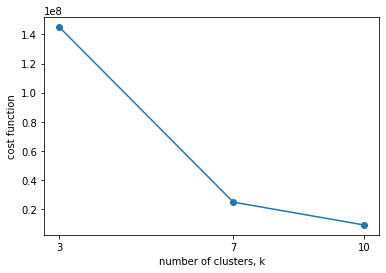

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot k vs cost_function
plt.plot(ks, costfunction, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('cost function')
plt.xticks(ks)
plt.show()